# U-Net for Image Segmentation: A Complete Educational Guide

## Introduction

This notebook provides a comprehensive educational guide to implementing U-Net architecture for semantic image segmentation using the Carvana Image Masking Challenge dataset. U-Net is a convolutional neural network architecture specifically designed for biomedical image segmentation, but it has proven effective for many other segmentation tasks.

### What You Will Learn

1. Understanding U-Net architecture and its components
2. Data preprocessing techniques for image segmentation
3. Implementation of encoder-decoder networks with skip connections
4. Training strategies for segmentation models
5. Evaluation metrics for segmentation tasks
6. Practical application on real-world dataset

### Dataset Overview

The Carvana Image Masking Challenge dataset contains high-resolution images of cars photographed from different angles, along with their corresponding binary masks that segment the car from the background. This dataset is perfect for learning image segmentation techniques.

### Prerequisites

- Basic understanding of deep learning concepts
- Familiarity with convolutional neural networks
- Python programming knowledge
- Understanding of image processing fundamentals

## 1. Import Required Libraries

### Step-by-Step Instructions:

1. **Deep Learning Framework**: Import TensorFlow and Keras for building and training the neural network
   - Import tensorflow as tf
   - Import specific Keras modules: layers, models, optimizers, callbacks
   - Set random seeds for reproducibility

2. **Data Manipulation**: Import libraries for handling arrays and data structures
   - Import NumPy for numerical operations
   - Import Pandas for data manipulation and CSV handling
   - Import os and glob for file system operations

3. **Image Processing**: Import libraries for image operations
   - Import OpenCV (cv2) for image preprocessing
   - Import PIL (Python Imaging Library) for image loading and manipulation
   - Import skimage for additional image processing functions

4. **Visualization**: Import plotting libraries
   - Import Matplotlib for creating plots and visualizations
   - Import seaborn for enhanced statistical visualizations
   - Set up matplotlib inline for Jupyter notebook display

5. **Utility Libraries**: Import additional helpful libraries
   - Import tqdm for progress bars during training
   - Import warnings to suppress unnecessary warnings
   - Import json for configuration file handling

### Why These Libraries?

- **TensorFlow/Keras**: Primary framework for building the U-Net model
- **NumPy**: Essential for array operations and mathematical computations
- **OpenCV**: Efficient image processing and computer vision operations
- **Matplotlib**: Visualizing training progress and results
- **tqdm**: Monitoring training and data loading progress

In [25]:
import tensorflow as tf
from keras import layers, models, optimizers, callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import cv2, skimage
import random, os, glob, json, tqdm

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

## 2. Download and Extract Carvana Dataset

1. **Download the Dataset**:
   - Use Kaggle API to download the Carvana Image Masking Challenge dataset
   - Command: `kaggle competitions download -c carvana-image-masking-challenge`
   - This will download all competition files including:
     - Train images (train.zip)
     - Train masks (train_masks.zip)
     - Test images (test.zip)
     - Sample submission file
     - Metadata

2. **Extract the Files**:
   - Create organized directory structure for the project
   - Extract train.zip to train/ folder
   - Extract train_masks.zip to train_masks/ folder
   - Extract test.zip to test/ folder
   - Keep the original zip files for backup

5. **Verify Dataset Structure**:
   - Check that all folders contain expected files
   - Verify image and mask file naming conventions
   - Count total number of training images and masks
   - Ensure masks correspond to training images

### Expected Directory Structure:
```
carvana-dataset/
├── train/                 # Training images
├── train_masks/          # Training masks (binary images)
├── test/                 # Test images
├── sample_submission.csv # Sample submission format
└── metadata.csv         # Additional dataset information
```

### Important Notes:
- Dataset size is approximately 5GB
- Training set contains 5,088 images
- Each car is photographed from 16 different angles
- Masks are binary images (car = white, background = black)

In [26]:
# # 2. Download and Extract Carvana Dataset

# # Download the dataset using Kaggle API
# # !kaggle competitions download -c carvana-image-masking-challenge -p ./carvana-dataset

# # Extract the files
# # import zipfile
# # with zipfile.ZipFile('./carvana-dataset/train.zip', 'r') as zip_ref:
# #     zip_ref.extractall('./carvana-dataset/train/')
# # with zipfile.ZipFile('./carvana-dataset/train_masks.zip', 'r') as zip_ref:
# #     zip_ref.extractall('./carvana-dataset/train_masks/')
# # with zipfile.ZipFile('./carvana-dataset/test.zip', 'r') as zip_ref:
# #     zip_ref.extractall('./carvana-dataset/test/')

# # Verify dataset structure
# # import os
# # print("Train images:", len(os.listdir('./carvana-dataset/train/')))
# # print("Train masks:", len(os.listdir('./carvana-dataset/train_masks/')))
# # print("Test images:", len(os.listdir('./carvana-dataset/test/')))
# # print("Sample submission exists:", os.path.exists('./carvana-dataset/sample_submission.csv'))
# # print("Metadata exists:", os.path.exists('./carvana-dataset/metadata.csv'))

## 3. Data Exploration and Visualization

1. **Dataset Overview**:
   - Count total number of training images and masks
   - List first few image filenames to understand naming convention
   - Check if every training image has a corresponding mask

In [27]:
# ---------------------------------------------------------------------------- #
#                                  DIRECTORIES                                 #
# ---------------------------------------------------------------------------- #

TRAIN_IMAGES_DIR = "carvana-dataset/train"
TRAIN_MASKS_DIR = "carvana-dataset/train_masks"
TEST_IMAGES_DIR = "carvana-dataset/test"

# ---------------------------------------------------------------------------- #
#                       LISTS TO STORE IMAGE DIRECTORIES                       #
# ---------------------------------------------------------------------------- #

train_set = []
train_mask_set = []
test_set = []

# ---------------------------------------------------------------------------- #
#                        PRINT COUNT OF IMAGES AND MASKS                       #
# ---------------------------------------------------------------------------- #

print("Train images: ", len(glob.glob(os.path.join(TRAIN_IMAGES_DIR, "*.*"))))
print("Train masks: ", len(glob.glob(os.path.join(TRAIN_MASKS_DIR, "*.*"))))
print("Test images: ", len(glob.glob(os.path.join(TEST_IMAGES_DIR, "*.*"))))

# ---------------------------------------------------------------------------- #
#                                APPENDING LISTS                               #
# ---------------------------------------------------------------------------- #

# TRAINING IMAGES
if os.path.exists(TRAIN_IMAGES_DIR):
    for image_filename in os.listdir(TRAIN_IMAGES_DIR):
        # Create full path to the image
        image_path = os.path.join(TRAIN_IMAGES_DIR, image_filename)
        train_set.append(image_path)
else:
    print(f"Directory {TRAIN_IMAGES_DIR} not found. Please check if the dataset is extracted correctly.")

# TRAINING MASKS
if os.path.exists(TRAIN_MASKS_DIR):
    for image_filename in os.listdir(TRAIN_MASKS_DIR):
        # Create full path to the image
        image_path = os.path.join(TRAIN_MASKS_DIR, image_filename)
        train_mask_set.append(image_path)
else:
    print(f"Directory {TRAIN_MASKS_DIR} not found. Please check if the dataset is extracted correctly.")

# TEST IMAGES
if os.path.exists(TEST_IMAGES_DIR):
    for image_filename in os.listdir(TEST_IMAGES_DIR):
        # Create full path to the image
        image_path = os.path.join(TEST_IMAGES_DIR, image_filename)
        test_set.append(image_path)
else:
    print(f"Directory {TEST_IMAGES_DIR} not found. Please check if the dataset is extracted correctly.")

# Print samples
print(train_set[:4])
print(train_mask_set[:4])
print(test_set[:4])

Train images:  5088
Train masks:  5088
Test images:  100064
['carvana-dataset/train\\00087a6bd4dc_01.jpg', 'carvana-dataset/train\\00087a6bd4dc_02.jpg', 'carvana-dataset/train\\00087a6bd4dc_03.jpg', 'carvana-dataset/train\\00087a6bd4dc_04.jpg']
['carvana-dataset/train_masks\\00087a6bd4dc_01_mask.gif', 'carvana-dataset/train_masks\\00087a6bd4dc_02_mask.gif', 'carvana-dataset/train_masks\\00087a6bd4dc_03_mask.gif', 'carvana-dataset/train_masks\\00087a6bd4dc_04_mask.gif']
['carvana-dataset/test\\0004d4463b50_01.jpg', 'carvana-dataset/test\\0004d4463b50_02.jpg', 'carvana-dataset/test\\0004d4463b50_03.jpg', 'carvana-dataset/test\\0004d4463b50_04.jpg']


2. **Image Properties Analysis**:
   - Load several sample images and examine their properties:
     - Image dimensions (height, width, channels)
     - Color space (RGB, BGR)

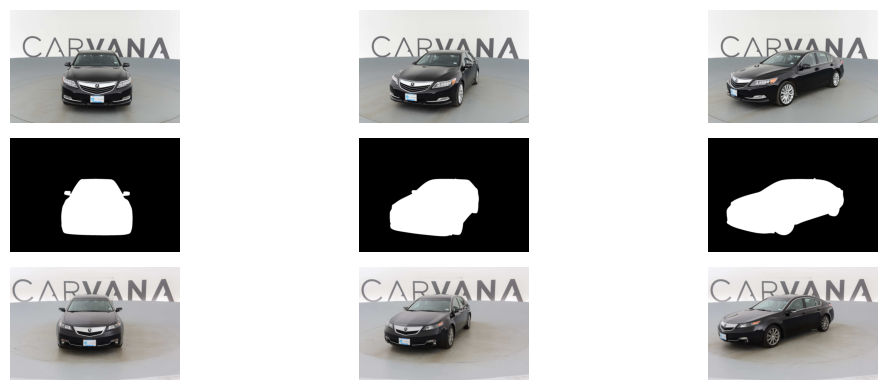

Format:  JPEG
Size: (1918, 1280)
Mode: RGB
Info: {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
Palette: None

Format:  JPEG
Size: (1918, 1280)
Mode: RGB
Info: {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
Palette: None

Format:  JPEG
Size: (1918, 1280)
Mode: RGB
Info: {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}
Palette: None

Format:  GIF
Size: (1918, 1280)
Mode: P
Info: {'version': b'GIF89a', 'background': 1, 'duration': 0}
Palette: <PIL.ImagePalette.ImagePalette object at 0x00000136801A4100>

Format:  GIF
Size: (1918, 1280)
Mode: P
Info: {'version': b'GIF89a', 'background': 1, 'duration': 0}
Palette: <PIL.ImagePalette.ImagePalette object at 0x00000136801A6980>

Format:  GIF
Size: (1918, 1280)
Mode: P
Info: {'version': b'GIF89a', 'background': 1, 'duration': 0}
Palette: <PIL.ImagePalette.ImagePalette object at 0x00000136801A41F0>

Format:  JPEG
Size: (1918, 1280)
Mode: RGB
Info: {'jfif': 

In [ ]:
# ---------------------------------------------------------------------------- #
#                                LOADING IMAGES                                #
# ---------------------------------------------------------------------------- #

images_to_display = train_set[:3] + train_mask_set[:3] + test_set[:3]
images = [Image.open(path) for path in images_to_display]

fig, axes = plt.subplots(3, 3, figsize=(12, 4))
for ax, img in zip(axes.flat, images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------- #
#                               IMAGE PROPERTIES                               #
# ---------------------------------------------------------------------------- #

for img in images:
    print("Format: ", img.format)
    print("Size:", img.size)
    print("Mode:", img.mode)
    print("Info:", img.info)
    print("Palette:", img.palette)
    print("")


3. **Mask Properties Analysis**:
   - Load corresponding mask images and analyze:
     - Mask dimensions (should match original images)
     - Pixel value distribution (0 for background, 255 for car)
     - Data type and format
     - Verify binary nature of masks

4. **Visual Exploration**:
   - Display a grid of sample images with their corresponding masks
   - Show original image, mask, and masked image side by side
   - Create visualizations showing:
     - Different car types and colors
     - Various camera angles (16 per car)
     - Mask complexity variations

5. **Statistical Analysis**:
   - Calculate mask coverage statistics:
     - Average percentage of car pixels per image
     - Distribution of car sizes in images
     - Aspect ratio analysis
   - Create histograms showing:
     - Image brightness distributions
     - Mask area distributions
     - Color channel statistics

6. **Data Quality Checks**:
   - Identify any corrupted or missing files
   - Check for any images without corresponding masks
   - Verify mask quality (clean edges, no artifacts)
   - Look for potential data anomalies

### Key Insights to Document:
- Image resolution: 1918 x 1280 pixels
- All images are high-quality RGB photos
- Masks are clean binary images
- Dataset is well-balanced with various car types
- 16 different viewing angles provide good coverage

## 4. Data Preprocessing and Augmentation

### Step-by-Step Instructions:

1. **Image Resizing Strategy**:
   - Determine target image size for training (e.g., 256x256, 512x512)
   - Consider memory constraints vs. model performance trade-offs
   - Implement resizing function that maintains aspect ratio
   - Handle both images and masks consistently
   - Choose appropriate interpolation methods (bilinear for images, nearest for masks)

2. **Normalization Techniques**:
   - Normalize pixel values to [0, 1] range by dividing by 255
   - Consider alternative normalization strategies:
     - Standard normalization (mean=0, std=1)
     - Per-channel normalization using ImageNet statistics
   - Ensure masks remain binary (0 and 1) after preprocessing

3. **Data Loading Pipeline**:
   - Create efficient data generator/loader functions
   - Implement batch loading for memory efficiency
   - Set up train/validation split (e.g., 80/20 or 90/10)
   - Ensure reproducible splits using fixed random seeds
   - Handle file path management and error checking

4. **Data Augmentation Strategies**:
   - **Geometric Transformations**:
     - Horizontal and vertical flipping
     - Random rotation (small angles, e.g., ±15 degrees)
     - Elastic deformation for more robust training
     - Random cropping and scaling
   
   - **Photometric Augmentations**:
     - Brightness adjustment (±20%)
     - Contrast modification
     - Color jittering (hue, saturation adjustments)
     - Gaussian noise addition
   
   - **Advanced Augmentations**:
     - Random shadow and highlight simulation
     - Perspective transformation
     - Motion blur effects
     - Weather condition simulation

5. **Augmentation Implementation Guidelines**:
   - Apply same geometric transformations to both image and mask
   - Only apply photometric changes to images, not masks
   - Use appropriate probability values for each augmentation
   - Create augmentation pipeline using libraries like Albumentations
   - Ensure augmented masks remain binary

6. **Validation Strategy**:
   - Keep validation set without augmentation for fair evaluation
   - Implement stratified splitting to ensure balanced validation
   - Consider cross-validation for more robust model evaluation
   - Monitor augmentation effects on training convergence

### Key Considerations:
- Balance between augmentation diversity and training stability
- Ensure augmentations are realistic and don't break data distribution
- Memory management for large datasets
- Reproducibility through proper seeding

## 5. U-Net Architecture Implementation

### Understanding U-Net Architecture:

U-Net consists of two main paths:
- **Contracting Path (Encoder)**: Captures context through downsampling
- **Expanding Path (Decoder)**: Enables precise localization through upsampling
- **Skip Connections**: Combine low-level and high-level features

### Step-by-Step Implementation:

1. **Encoder (Contracting Path) Design**:
   - **Input Layer**: Accept images of size (height, width, 3)
   - **Encoder Block Structure**:
     - Two 3x3 convolutions with ReLU activation
     - Batch normalization after each convolution
     - Dropout for regularization (0.1-0.2)
     - 2x2 max pooling for downsampling
   
   - **Encoder Levels**:
     - Level 1: 64 filters, input size
     - Level 2: 128 filters, 1/2 input size
     - Level 3: 256 filters, 1/4 input size
     - Level 4: 512 filters, 1/8 input size

2. **Bottleneck (Bridge) Design**:
   - Located at the lowest resolution (1/16 input size)
   - Two 3x3 convolutions with 1024 filters
   - Higher dropout rate (0.3-0.5) for regularization
   - No max pooling (preparation for upsampling)

3. **Decoder (Expanding Path) Design**:
   - **Decoder Block Structure**:
     - 2x2 transpose convolution for upsampling
     - Concatenation with corresponding encoder features (skip connections)
     - Two 3x3 convolutions with ReLU activation
     - Batch normalization and dropout
   
   - **Decoder Levels**:
     - Level 1: Upsample to 1/8, concatenate with encoder level 4
     - Level 2: Upsample to 1/4, concatenate with encoder level 3
     - Level 3: Upsample to 1/2, concatenate with encoder level 2
     - Level 4: Upsample to full size, concatenate with encoder level 1

4. **Skip Connections Implementation**:
   - Store encoder feature maps at each level
   - Concatenate along channel dimension in decoder
   - Ensure spatial dimensions match for concatenation
   - Handle any size mismatches through cropping or padding

5. **Output Layer Design**:
   - Final 1x1 convolution to reduce channels to number of classes
   - For binary segmentation: 1 output channel
   - Sigmoid activation for binary classification
   - Ensure output size matches input size

6. **Advanced Architecture Considerations**:
   - **Residual Connections**: Add within encoder/decoder blocks
   - **Attention Mechanisms**: Focus on important features
   - **Deep Supervision**: Add auxiliary outputs at multiple scales
   - **Dense Connections**: Connect all previous layers

### Architecture Benefits:
- **Skip Connections**: Preserve spatial information lost during downsampling
- **Symmetric Design**: Balanced encoder-decoder structure
- **Multi-scale Features**: Combines different levels of abstraction
- **End-to-End Training**: Single network for complete segmentation pipeline

### Implementation Tips:
- Use appropriate padding to maintain spatial dimensions
- Consider memory requirements when choosing filter numbers
- Experiment with different activation functions and normalizations
- Monitor gradient flow through the deep network

## 6. Model Compilation and Training Setup

### Step-by-Step Instructions:

1. **Loss Function Selection**:
   - **Binary Cross-Entropy**: Standard for binary segmentation
     - Well-suited for pixel-wise classification
     - Handles class imbalance moderately well
   
   - **Dice Loss**: Focuses on overlap between prediction and ground truth
     - Better for handling class imbalance
     - Directly optimizes the Dice coefficient metric
   
   - **Combined Loss**: Binary cross-entropy + Dice loss
     - Balances pixel-wise accuracy and overlap
     - Often provides best results for segmentation
   
   - **Focal Loss**: Addresses hard example mining
     - Reduces impact of easy examples
     - Focuses on difficult boundary pixels

2. **Optimizer Configuration**:
   - **Adam Optimizer**: Good default choice
     - Learning rate: 1e-3 to 1e-4
     - Beta1: 0.9, Beta2: 0.999
     - Adaptive learning rates for each parameter
   
   - **SGD with Momentum**: Alternative for stable training
     - Learning rate: 1e-2 to 1e-3
     - Momentum: 0.9
     - May require more careful tuning
   
   - **Learning Rate Scheduling**:
     - ReduceLROnPlateau: Reduce when validation loss plateaus
     - CosineAnnealingLR: Cyclical learning rate changes
     - ExponentialDecay: Gradual learning rate reduction

3. **Evaluation Metrics Setup**:
   - **IoU (Intersection over Union)**:
     - Primary metric for segmentation tasks
     - Measures overlap between prediction and ground truth
     - Range: 0 to 1 (higher is better)
   
   - **Dice Coefficient**:
     - Similar to IoU but with different mathematical formulation
     - Also measures overlap quality
     - More sensitive to small objects
   
   - **Pixel Accuracy**:
     - Percentage of correctly classified pixels
     - Can be misleading with class imbalance
   
   - **Precision and Recall**:
     - Precision: True positives / (True positives + False positives)
     - Recall: True positives / (True positives + False negatives)

4. **Callback Configuration**:
   - **ModelCheckpoint**:
     - Save best model based on validation metric
     - Monitor validation IoU or validation loss
     - Save only when improvement is detected
     - Keep backup of best weights
   
   - **EarlyStopping**:
     - Stop training when validation metric stops improving
     - Patience: 10-20 epochs
     - Restore best weights when stopping
   
   - **ReduceLROnPlateau**:
     - Reduce learning rate when training plateaus
     - Factor: 0.5 (reduce by half)
     - Patience: 5-10 epochs
     - Minimum learning rate: 1e-7
   
   - **CSVLogger**:
     - Log training metrics to CSV file
     - Useful for post-training analysis
     - Track loss and metric evolution

5. **Training Configuration**:
   - **Batch Size Selection**:
     - Balance between memory constraints and training stability
     - Typical values: 8, 16, 32 (depending on GPU memory)
     - Smaller batches may need adjusted learning rate
   
   - **Epoch Planning**:
     - Start with 50-100 epochs
     - Monitor for overfitting or underfitting
     - Adjust based on learning curves
   
   - **Validation Strategy**:
     - Use separate validation set (not used in training)
     - Evaluate every epoch
     - Monitor both loss and custom metrics

### Best Practices:
- Start with proven hyperparameters and adjust gradually
- Monitor training curves to detect overfitting early
- Use mixed precision training for memory efficiency
- Implement gradient clipping if training becomes unstable
- Save model architecture separately from weights

## 7. Train the U-Net Model

### Step-by-Step Instructions:

1. **Pre-Training Preparation**:
   - Verify data generators are working correctly
   - Test model architecture with a small batch
   - Ensure all paths and dependencies are properly set
   - Clear any previous model states or cached data
   - Set up logging and monitoring systems

2. **Training Process Initiation**:
   - Start the training process using model.fit() or custom training loop
   - Monitor initial loss values to ensure proper initialization
   - Check that gradients are flowing properly (not too large or small)
   - Verify that data loading is efficient (no bottlenecks)

3. **Training Monitoring Strategy**:
   - **Real-time Metrics Tracking**:
     - Monitor training and validation loss curves
     - Track IoU and Dice coefficient progression
     - Watch for signs of overfitting (validation loss increasing)
     - Monitor learning rate changes from schedulers
   
   - **Visual Progress Monitoring**:
     - Periodically visualize predictions on validation samples
     - Compare predictions at different training stages
     - Create side-by-side comparisons of original, ground truth, and prediction
     - Save sample predictions at regular intervals

4. **Training Curve Analysis**:
   - **Healthy Training Signs**:
     - Both training and validation loss decreasing
     - Validation metrics improving steadily
     - No large spikes or instabilities
     - Learning rate reductions leading to continued improvement
   
   - **Overfitting Detection**:
     - Training loss continues to decrease while validation loss increases
     - Large gap between training and validation metrics
     - Validation metrics plateau or degrade
   
   - **Underfitting Indicators**:
     - Both training and validation loss plateau at high values
     - Model predictions look poor on validation samples
     - Metrics remain low despite adequate training time

5. **Training Optimization Strategies**:
   - **If Overfitting Occurs**:
     - Increase dropout rates
     - Add more data augmentation
     - Reduce model complexity
     - Implement early stopping
     - Use regularization techniques
   
   - **If Underfitting Occurs**:
     - Increase model capacity (more filters/layers)
     - Reduce regularization
     - Increase learning rate
     - Train for more epochs
     - Check data quality and preprocessing

6. **Progress Visualization**:
   - Create plots showing loss evolution over epochs
   - Plot IoU and Dice coefficient trends
   - Generate learning rate schedules visualization
   - Create confusion matrices for validation set
   - Show sample predictions at different training stages

7. **Checkpoint Management**:
   - Regularly save model checkpoints
   - Keep multiple backup checkpoints
   - Monitor disk space usage
   - Implement automatic cleanup of old checkpoints
   - Save best model based on validation metrics

8. **Training Completion**:
   - Allow training to complete or trigger early stopping
   - Load the best model checkpoint
   - Save final model weights and architecture
   - Document final training metrics
   - Create comprehensive training report

### Expected Training Timeline:
- **Initial epochs (1-10)**: Rapid loss decrease, basic shape learning
- **Middle epochs (10-30)**: Refinement of boundaries, metric improvement
- **Final epochs (30+)**: Fine-tuning, potential overfitting watch
- **Total time**: Several hours to days depending on hardware and dataset size

### Troubleshooting Common Issues:
- **NaN losses**: Check learning rate, data normalization, or loss function
- **Slow training**: Verify data loading efficiency, consider mixed precision
- **Memory issues**: Reduce batch size, optimize data pipeline
- **Poor convergence**: Adjust learning rate, check data quality

## 8. Model Evaluation and Metrics

### Step-by-Step Instructions:

1. **Load Best Model**:
   - Load the model checkpoint with the best validation performance
   - Verify model architecture is intact
   - Ensure proper weight loading without errors
   - Test model with a sample input to confirm functionality

2. **Comprehensive Metric Calculation**:
   
   **A. IoU (Intersection over Union)**:
   - Calculate for each image in validation/test set
   - Formula: IoU = (True Positives) / (True Positives + False Positives + False Negatives)
   - Compute mean IoU across all test images
   - Analyze IoU distribution and identify outliers
   
   **B. Dice Coefficient**:
   - Calculate pixel-wise Dice score for each prediction
   - Formula: Dice = 2 * (True Positives) / (2 * True Positives + False Positives + False Negatives)
   - Report mean and standard deviation across test set
   - Compare with IoU results for consistency
   
   **C. Pixel Accuracy**:
   - Calculate percentage of correctly classified pixels
   - Formula: Accuracy = (True Positives + True Negatives) / Total Pixels
   - Note limitations due to class imbalance
   
   **D. Precision and Recall**:
   - Precision = True Positives / (True Positives + False Positives)
   - Recall = True Positives / (True Positives + False Negatives)
   - Calculate F1-score: 2 * (Precision * Recall) / (Precision + Recall)

3. **Confusion Matrix Analysis**:
   - Create pixel-level confusion matrix
   - Visualize as heatmap for easy interpretation
   - Calculate additional metrics from confusion matrix:
     - Specificity (True Negative Rate)
     - False Positive Rate
     - False Negative Rate
   - Analyze class-wise performance

4. **Error Analysis**:
   - **Identify Failure Cases**:
     - Images with lowest IoU scores
     - Common failure patterns (shadows, reflections, similar colors)
     - Challenging scenarios (partial occlusion, complex backgrounds)
   
   - **Boundary Analysis**:
     - Evaluate performance at object boundaries
     - Measure boundary precision and recall
     - Identify systematic boundary errors
   
   - **Size-based Analysis**:
     - Performance on small vs. large objects
     - Correlation between object size and accuracy
     - Identify size-related biases

5. **Comparative Analysis**:
   - **Baseline Comparison**:
     - Compare against simple threshold-based methods
     - Benchmark against other segmentation algorithms
     - Document improvement over baseline approaches
   
   - **Ablation Studies**:
     - Impact of different loss functions
     - Effect of data augmentation strategies
     - Skip connection importance analysis
     - Architecture component contributions

6. **Statistical Significance Testing**:
   - Perform statistical tests on metric distributions
   - Calculate confidence intervals for mean metrics
   - Test for significant differences between model variants
   - Report statistical significance of improvements

7. **Visualization of Results**:
   - Create metric distribution histograms
   - Plot correlation between different metrics
   - Generate box plots for metric comparisons
   - Create scatter plots of metrics vs. image characteristics

8. **Performance Benchmarking**:
   - **Speed Analysis**:
     - Measure inference time per image
     - Analyze memory usage during inference
     - Compare with other model architectures
   
   - **Scalability Testing**:
     - Performance on different image sizes
     - Batch processing efficiency
     - GPU vs. CPU inference comparison

9. **Model Robustness Evaluation**:
   - Test on images with different characteristics:
     - Various lighting conditions
     - Different car colors and types
     - Diverse backgrounds
     - Different image qualities
   
   - **Generalization Assessment**:
     - Performance on held-out test set
     - Cross-validation results
     - Sensitivity to hyperparameter changes

### Expected Performance Benchmarks:
- **Good IoU**: > 0.85 for car segmentation
- **Excellent IoU**: > 0.90
- **Dice Coefficient**: Should be similar to IoU values
- **Pixel Accuracy**: Often > 0.95 but can be misleading
- **Processing Time**: < 100ms per image for real-time applications

### Documentation Requirements:
- Create comprehensive evaluation report
- Include visualizations of all key metrics
- Document methodology and assumptions
- Provide recommendations for model improvement

## 9. Prediction and Visualization

### Step-by-Step Instructions:

1. **Prediction Pipeline Setup**:
   - Load the trained model with best weights
   - Prepare prediction function with proper preprocessing
   - Ensure input images are processed consistently with training data
   - Set up batch prediction for efficiency
   - Handle different input image sizes if necessary

2. **Single Image Prediction Process**:
   - **Image Preprocessing**:
     - Resize image to model input size
     - Normalize pixel values to [0, 1] range
     - Add batch dimension for model input
     - Ensure correct data type (float32)
   
   - **Model Inference**:
     - Pass preprocessed image through trained model
     - Apply sigmoid activation to get probabilities
     - Convert probabilities to binary mask using threshold (typically 0.5)
     - Remove batch dimension from output
   
   - **Post-processing**:
     - Resize prediction back to original image size
     - Apply morphological operations for noise reduction
     - Smooth boundaries if necessary
     - Convert to appropriate format for visualization

3. **Batch Prediction Strategy**:
   - Process multiple images efficiently
   - Use appropriate batch sizes based on memory constraints
   - Implement progress tracking for large test sets
   - Handle memory management for large datasets
   - Save predictions systematically

4. **Visualization Techniques**:
   
   **A. Side-by-Side Comparison**:
   - Create three-panel displays: Original | Ground Truth | Prediction
   - Use consistent color schemes across all visualizations
   - Add titles and labels for clarity
   - Highlight differences between ground truth and prediction
   
   **B. Overlay Visualizations**:
   - Overlay predicted mask on original image with transparency
   - Use distinct colors for different regions (car vs. background)
   - Create contour overlays showing predicted boundaries
   - Show confidence maps with color coding
   
   **C. Error Visualization**:
   - Highlight false positive regions (predicted car, actually background)
   - Show false negative regions (missed car pixels)
   - Create difference maps showing prediction errors
   - Use color coding: green for correct, red for false positive, blue for false negative

5. **Comprehensive Result Gallery**:
   - **Best Predictions**: Show examples with highest IoU scores
   - **Challenging Cases**: Display difficult scenarios the model handles well
   - **Failure Cases**: Analyze and visualize poor predictions
   - **Edge Cases**: Show performance on unusual or difficult images
   - **Progressive Examples**: Show predictions at different training stages

6. **Interactive Visualizations**:
   - Create sliders to adjust prediction threshold
   - Interactive plots showing effect of different post-processing
   - Zoom functionality for detailed boundary analysis
   - Toggle between different visualization modes

7. **Quantitative Visualization**:
   - **Metric Overlays**: Show IoU and Dice scores on each image
   - **Confidence Maps**: Visualize model certainty across different regions
   - **Boundary Quality**: Highlight boundary precision
   - **Size Analysis**: Color-code predictions by object size

8. **Comparative Analysis Visualization**:
   - Compare with baseline methods (simple thresholding, traditional CV)
   - Show improvements over different model iterations
   - Visualize ensemble predictions if multiple models are used
   - Display performance across different image categories

9. **Export and Documentation**:
   - Save high-quality prediction images for reports
   - Create summary visualizations showing overall performance
   - Generate prediction videos for dynamic visualization
   - Export results in various formats (PNG, PDF, etc.)

10. **Quality Assessment Visualization**:
    - **Boundary Analysis**: Zoom into boundary regions
    - **Texture Analysis**: Show performance on different textures
    - **Lighting Analysis**: Performance under different lighting conditions
    - **Scale Analysis**: Results on different car sizes

### Visualization Best Practices:
- Use consistent color schemes throughout
- Provide clear legends and labels
- Ensure high resolution for detailed analysis
- Include quantitative metrics in visualizations
- Create both individual and summary visualizations
- Make visualizations accessible and interpretable

### Advanced Visualization Techniques:
- **Attention Visualization**: Show which parts of the image the model focuses on
- **Feature Map Visualization**: Display intermediate layer activations
- **Gradient Visualization**: Show important regions for predictions
- **Uncertainty Visualization**: Display model confidence levels

## 10. Save and Load Model

### Step-by-Step Instructions:

1. **Model Saving Strategies**:
   
   **A. Complete Model Saving**:
   - Save entire model including architecture, weights, and optimizer state
   - Use model.save() for TensorFlow/Keras models
   - Creates a single file containing everything needed for inference
   - Recommended for deployment and sharing
   - Format: .h5 or SavedModel format
   
   **B. Weights-Only Saving**:
   - Save only the trained weights using model.save_weights()
   - Requires separate architecture definition for loading
   - More storage efficient
   - Useful when architecture might change
   - Format: .h5 or checkpoint files

2. **Architecture Documentation**:
   - Save model architecture as JSON or YAML
   - Document model configuration parameters
   - Save hyperparameters used during training
   - Create model summary and layer information
   - Store preprocessing parameters and requirements

3. **Comprehensive Saving Process**:
   - **Best Model Checkpoint**: Save model with highest validation performance
   - **Final Model**: Save model at end of training
   - **Multiple Checkpoints**: Save models at different training stages
   - **Backup Strategy**: Create multiple copies for safety
   - **Version Control**: Include timestamp and version information

4. **Metadata and Configuration Saving**:
   - **Training Configuration**:
     - Learning rate schedules used
     - Data augmentation parameters
     - Batch size and epoch information
     - Loss function and optimizer settings
   
   - **Data Configuration**:
     - Input image dimensions
     - Normalization parameters
     - Class information and labels
     - Dataset statistics and splits
   
   - **Performance Metrics**:
     - Final evaluation scores
     - Training history and curves
     - Best achieved metrics
     - Computational requirements

5. **Model Loading Process**:
   
   **A. Complete Model Loading**:
   - Load entire model using tf.keras.models.load_model()
   - Verify model integrity after loading
   - Test with sample input to ensure functionality
   - Check that predictions match expected behavior
   
   **B. Architecture + Weights Loading**:
   - Reconstruct model architecture from saved configuration
   - Load weights using model.load_weights()
   - Verify architecture matches saved weights
   - Compile model with appropriate settings

6. **Model Verification After Loading**:
   - **Functionality Testing**:
     - Run prediction on test image
     - Compare results with expected outputs
     - Verify output dimensions and data types
     - Check prediction consistency
   
   - **Performance Verification**:
     - Re-evaluate on validation set
     - Confirm metrics match saved values
     - Test inference speed and memory usage
     - Validate preprocessing pipeline

7. **Deployment Preparation**:
   - **Model Optimization**:
     - Convert to optimized formats (TensorRT, ONNX)
     - Apply quantization if needed
     - Create lightweight versions for mobile deployment
     - Test optimized models for accuracy retention
   
   - **Inference Pipeline**:
     - Create complete inference script
     - Include all preprocessing steps
     - Add error handling and validation
     - Document input/output specifications

8. **Version Management**:
   - **Model Versioning**:
     - Use semantic versioning (v1.0.0, v1.1.0, etc.)
     - Track changes between versions
     - Maintain compatibility documentation
     - Create migration guides for version updates
   
   - **Experiment Tracking**:
     - Link models to specific experiments
     - Track hyperparameter changes
     - Maintain training logs and metrics
     - Document model lineage and improvements

9. **Storage and Organization**:
   - **File Structure**:
     - Organize models by experiment date and version
     - Create separate folders for different model variants
     - Include README files with model descriptions
     - Maintain consistent naming conventions
   
   - **Backup Strategy**:
     - Store models in multiple locations
     - Use cloud storage for important models
     - Create compressed archives for long-term storage
     - Implement automated backup procedures

10. **Sharing and Distribution**:
    - **Model Packaging**:
      - Create complete packages with dependencies
      - Include usage examples and documentation
      - Provide model cards with performance information
      - Package with sample data for testing
    
    - **Documentation**:
      - Create comprehensive user guides
      - Include API documentation
      - Provide performance benchmarks
      - Add troubleshooting information

### Best Practices:
- Always test loaded models before deployment
- Include checksums for model integrity verification
- Document all dependencies and requirements
- Create automated testing for model loading
- Maintain backwards compatibility when possible
- Use descriptive naming conventions for model files

### File Organization Example:
```
models/
├── unet_carvana_v1.0/
│   ├── model.h5                 # Complete saved model
│   ├── weights.h5              # Model weights only
│   ├── architecture.json       # Model architecture
│   ├── config.yaml            # Training configuration
│   ├── metrics.json           # Performance metrics
│   ├── preprocessing.py       # Preprocessing functions
│   └── README.md             # Model documentation
└── checkpoints/
    ├── epoch_010.h5
    ├── epoch_020.h5
    └── best_model.h5
```

## Conclusion and Next Steps

### Summary

This notebook has provided a comprehensive educational guide to implementing U-Net for image segmentation using the Carvana dataset. You have learned:

1. **U-Net Architecture**: Understanding the encoder-decoder structure with skip connections
2. **Data Handling**: Proper preprocessing, augmentation, and loading strategies
3. **Training Process**: Model compilation, training monitoring, and optimization
4. **Evaluation**: Comprehensive metrics and performance analysis
5. **Deployment**: Model saving, loading, and preparation for production use

### Key Takeaways

- **Skip Connections**: Critical for preserving spatial information in segmentation tasks
- **Data Augmentation**: Essential for robust model performance and generalization
- **Proper Evaluation**: Multiple metrics provide comprehensive performance assessment
- **Training Monitoring**: Early detection of overfitting and training issues is crucial
- **Systematic Approach**: Following structured methodology ensures reproducible results

### Potential Improvements and Extensions

1. **Architecture Enhancements**:
   - Implement Attention U-Net for better feature focusing
   - Try U-Net++ or UNet3+ for improved performance
   - Experiment with different encoder backbones (ResNet, EfficientNet)
   - Add pyramid pooling modules for multi-scale features

2. **Advanced Training Techniques**:
   - Implement focal loss for hard example mining
   - Use progressive resizing during training
   - Apply test-time augmentation for improved predictions
   - Experiment with different optimization strategies

3. **Data Enhancement**:
   - Implement more sophisticated augmentation techniques
   - Use synthetic data generation for dataset expansion
   - Apply domain adaptation techniques
   - Experiment with semi-supervised learning approaches

4. **Deployment Optimizations**:
   - Model quantization for mobile deployment
   - TensorRT optimization for GPU inference
   - Edge deployment using TensorFlow Lite
   - Real-time processing pipeline development

### Real-World Applications

The techniques learned in this notebook can be applied to various domains:

- **Medical Imaging**: Organ segmentation, tumor detection
- **Autonomous Vehicles**: Road segmentation, object detection
- **Agriculture**: Crop monitoring, disease detection
- **Satellite Imagery**: Land use classification, environmental monitoring
- **Manufacturing**: Quality control, defect detection

### Further Learning Resources

1. **Advanced Segmentation Architectures**: DeepLab, Mask R-CNN, SegFormer
2. **Medical Image Segmentation**: Specialized techniques and challenges
3. **Video Segmentation**: Temporal consistency and tracking
4. **3D Segmentation**: Volumetric data processing
5. **Weak Supervision**: Learning with limited annotations

### Final Notes

Remember that successful image segmentation projects require:
- High-quality, well-annotated data
- Careful hyperparameter tuning
- Proper validation strategies
- Comprehensive evaluation
- Systematic experimentation and documentation

The foundation provided in this notebook will serve as a solid starting point for tackling more complex segmentation challenges in your specific domain of interest.